## Quantum Hamiltonian reconstruction on nearest neighbor graph

Reconstruction is performed for Heizenberg XYZ Hamiltonian of the following form:

$$H = \sum_{{i,j}\in G}J^{xx}_{ij}\sigma^x_i\sigma^x_j + J^{yy}_{ij}\sigma^y_i \sigma^y_j 
+ J^{zz}_{ij}\sigma^z_i \sigma^z_j + \sum_{i\in G} h^x_i$$

Further in code, XYZ can be turned into any isotropic (XXX, XXZ, etc.) form by defining equal X Y and Z arrays of couplings

In [331]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy as sp
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
from sklearn.metrics import mean_squared_error as mse
from time import time, perf_counter
from scipy.optimize import minimize
import copy
from scipy.optimize import basinhopping
from sys import getsizeof
import pickle

In [332]:
# Lets remove Hermiticity checks!
no_checks={"check_herm":False,
           "check_pcon":False,
           "check_symm":False}    

# Define critical functions

In [333]:
##Gibbs density matrix calculation##

def density_matr (N_spins, Jxx, Jyy, Jzz, hx, beta):
    
    """Calculates Gibbs density matrix

    Args:
        N (int): number of spins 
        coupl_matr (np.array): J_ij 
                    coupling matrix
        field_vec (np.array): array of
            transverse magnetic fields
        beta (float): inverse temperature

    Returns:
        np.array:

    """   
    
    adj_mat = np.zeros ((N_spins, N_spins))
    tmp_mat = np.zeros ((N_spins - 1, N_spins - 1))
    np.fill_diagonal (tmp_mat, 1)
    adj_mat [:-1, 1:] = tmp_mat
    nz_ind = np.argwhere (adj_mat == 1).astype (object)
    
    basis = spin_basis_1d (N_spins)
    
    
    J_xx = np.insert (nz_ind, 0, Jxx, axis = 1).tolist ()
    J_yy = np.insert (nz_ind, 0, Jyy, axis = 1).tolist ()
    J_zz = np.insert (nz_ind, 0, Jzz, axis = 1).tolist ()
    h_x = [[hx [i], i] for i in range (N_spins)]
    
    
    static = [["xx", J_xx], ["yy", J_yy], ["zz", J_zz], ["x", h_x]]
        
    dynamic = []

    # generating hamiltonian
    H = hamiltonian (static, dynamic, basis = basis, 
                     **no_checks, dtype=np.float64)
    H = H.toarray ()
    #normalization constant
    Z = np.trace (sp.linalg.expm (-beta*H))
    #density matrix
    rho = sp.linalg.expm (-beta*H)/Z
    
    return rho

In [334]:
##Returns dictionary of angles for 3^N basis states#

def xyz_rot_angles (N_spins):
    
    """Returns dict with 3**N keys, corresponding to 3^N basis states
    
    Each key contains set of angles, corresponding to this basis state
    """
    
    ang_dict = dict ()
    
    #construction of x y z bases space
    bases_ternary = list ()

    for num in range (3**N_spins):
        ternary_basis = np.base_repr (num, 3)
        full_repr = '0' * (N_spins - len (ternary_basis)) + ternary_basis
        list_basis = list (full_repr)
        bases_ternary.append (list_basis)
        
    ang_array = np.array ([[np.pi/2, 0], [np.pi/2, np.pi/2], [0, 0]])  
    bases_ternary = np.array (bases_ternary)
    ang_blank = np.zeros ((N_spins, 2))
    
    for i in range (len (bases_ternary)):
        int_indices = bases_ternary [i].astype (int)
        ang_blank = ang_array [int_indices]
        key = ''.join (bases_ternary [i])
        ang_dict [key] = ang_blank
        
        
    return ang_dict

In [335]:
##Returns dictionary of angles for a defined number of random basis states#

def rand_rot_angles (N_spins, N_bases):
    
    """Returns dict with user defined number of keys, where each key 
    correspond to a random basis state (phi and theta are randomly chosen on a Bloch sphere)
    
    N_spins - number of spins in a chain
    N_bases - number of random bases
    
    """
    
    ang_dict = dict()
    
    bases = np.arange(N_bases)
        
    cos_thetas = [2*(np.random.rand (N_spins)-.5) for i in bases]
                  
    phis = [2*(np.random.rand (N_spins)-.5) for i in bases]
    
    for i in bases:
        
        angs_arr = np.zeros ((N_spins, 2))
        z = cos_thetas [i]
        theta = np.arccos (z)
        phi = phis [i]
        
        angs_arr [:, 0] = theta
        angs_arr [:, 1] = phi
        
        ang_dict [bases [i]] = angs_arr
    
    return ang_dict

In [336]:
##Calculates U and U_+ which will be further used to acces diagonal element of density matrix in log_like func##

def rot_matr (angles):
    
    """Calculates rotation matrices (and Hermitian conj) for the given set of {theta, phi} array

    Args:
        angles dict (from functions xyz_rot_angles or rand_rot_angles)

    Returns:
        dict(): dict['angles'],
                dict['rot_matr'],
                dict['rot_H']                
    """    
    
    upd_dict = dict()
    
    for key in list (angles.keys ()):
    
        it_ranges = angles [key].shape

        theta = angles [key] [0, 0]
        phi = angles [key] [0, 1]

        a = np.cos (theta/2) * np.exp(phi/2.*1j)
        b = np.sin (theta/2) * np.exp( - phi/2.*1j)
        c = -np.sin (theta/2) * np.exp(phi/2.*1j)
        d = np.cos (theta/2) * np.exp( - phi/2.*1j)

        U = np.array ([[a, b], [c, d]])

        for i in range (it_ranges [0] - 1):

            theta = angles [key] [i + 1, 0]
            phi = angles [key] [i + 1, 1]

            a = np.cos (theta/2) * np.exp(phi/2.*1j)
            b = np.sin (theta/2) * np.exp( - phi/2.*1j)
            c = -np.sin (theta/2) * np.exp(phi/2.*1j)
            d = np.cos (theta/2) * np.exp( - phi/2.*1j)
            

            U = np.kron (U, np.array ([[a, b], [c, d]])).astype ('complex64')
            
        matr_dict = dict()
        
        matr_dict ['angles'] = angles [key]
        
        matr_dict ['rot_matr'] = U
        
        U_asmatr = np.asmatrix (U)
        rot_H = U_asmatr.getH ()
        rot_H = rot_H.getA ()
        
        matr_dict ['rot_H'] = rot_H
        
        upd_dict [key] = matr_dict
        
    return upd_dict

In [337]:
#Return diagonal of denisty matrix, which will be sampled for the dataset#

def get_rho_diag (rho, rot_matrices):
    
    """Calculates diagonal elements of the density matrix 
    (corresponds to projective measurements)

    Args:
        rho(np.array): density matrix
        rot_matrices(dict): 

    Returns:
        dict():  dict['angles'],
                 dict['rot_matr'],
                 dict['rot_H'],
                 dict['rho_diag'],
    """  
    
    upd_dict = dict()
    
    for key in list(rot_matrices.keys ()):
        
        basis = {}
        
        rot_matr = rot_matrices [key] ['rot_matr']
        rot_H = rot_matrices [key] ['rot_H']
        rot_rho = np.dot (np.dot (rot_matr, rho), rot_H)
    
        diag = np.real (rot_rho.diagonal ())
        
        basis ['angles'] = rot_matrices [key] ['angles']
        basis ['rot_matr'] = rot_matr
        basis ['rot_H'] = rot_H
        basis ['diag'] = diag
        
        upd_dict [key] = basis
    
    return upd_dict

In [338]:
#From the dataset, returned by get_rho_diag, choose a batch dataset#

def get_batch_dataset (diag, N_rb, N_m):
    
    batch_ds = dict ()
    
    """
    N_rb - number of randomly chosen bases from the dataset
    N_m - number of projective measurements in each basis
    """
    
    rand_ints = np.random.choice (range (0, len (diag)), N_rb, replace = False)
    keys = np.array (list (diag.keys ()))
    selected_keys = keys [rand_ints]
    for key in selected_keys:
        basis = dict()
    
        s_arr = np.zeros (len (diag [key] ['diag']))
        s = 0
        for i in range (len (diag [key] ['diag'])):

            s += diag [key] ['diag'] [i]
            s_arr [i] = s

        result = np.zeros (N_m)
        for n in range (N_m):
            r = np.random.uniform (0, 1)
            for j in range (len (s_arr)):
                if r < s_arr [j]:
                    break
            result [n] = j + 1

        basis ['measurements'] = result
        basis ['rot_matr'] = diag [key] ['rot_matr']
        basis ['rot_H'] = diag [key] ['rot_H']
        batch_ds [key] = basis
        
    return batch_ds

In [393]:
#Return full dataset#

def get_dataset (diag, N_exp):
    
    """
    Returns dataset
    N_exp - number of measurements (samples from diagonal of density matrix)
    
    """
        
    dataset = dict()
    
    for key in list(diag.keys ()):        
        basis = dict()
    
        #s_arr = np.zeros (len (diag [key] ['diag']))
        #s = 0
        #for i in range (len (diag [key] ['diag'])):

        #    s += diag [key] ['diag'] [i]
        #    s_arr [i] = s
        s_arr = np.cumsum (diag [key] ['diag'])
        result = np.zeros (N_exp)
        r_arr = []
        #print ('-----')
        #print ('Basis: ', key)
        #print ('-----')
        for n in range (N_exp):
            #print ('Measurement ', n)
            r = np.random.uniform (0, 1)
            #print ('Random num: ', r)
            #print ('Cumsum: ', s_arr)
            for j in range (len (s_arr)):
                #print (j)
                if r < s_arr [j]:
                    break
            result [n] = j
            #print ('Interval: ', result [n])
            r_arr.append (r)
            #print ('-----')
        #print ('')
            
        basis ['measurements'] = result
        basis ['random'] = r_arr
        basis ['rot_matr'] = diag [key] ['rot_matr']
        basis ['rot_H'] = diag [key] ['rot_H']
        
        dataset [key] = basis
                
    return dataset

In [394]:
def random_bases_choice (dataset, N):
    
    rand_ds = dict ()
    
    """
    N - number of randomly chosen bases from the dataset
    """
    
    while True:
        rand_ints = np.random.randint (1, len (dataset), N)
        if len (np.unique (rand_ints)) == len (rand_ints):
            break 
    keys = np.array (list (dataset.keys ()))
    selected_keys = keys [rand_ints]
    for key in selected_keys:
        rand_ds [key] = dataset [key]
        
    return rand_ds  

# Prepare dataset

In [409]:
# Number of spins
N_spins = 4

#N_samples = 11000
#N_rand_bases = 1000
#N_measures = int (N_samples / N_rand_bases)


#couplings, transverse field
#XYZ hamiltonian, to create XXX use Jxx = Jyy = Jzz
Jyy = np.random.uniform (-1, 1, N_spins - 1)
Jxx = np.random.uniform (-1, 1, N_spins - 1)
Jzz = np.random.uniform (-1, 1, N_spins - 1)
hx = np.random.uniform (-1, 1, N_spins)
beta = 1



rho = density_matr (N_spins, Jxx, Jyy, Jzz, hx, beta)
rot_matrices_xyz = rot_matr (xyz_rot_angles(N_spins))
#rot_matrices_rand = rot_matr (rand_rot_angles(N_spins, 3**N_spins)) 
diag = get_rho_diag (rho, rot_matrices_xyz)
#batch_ds = get_batch_dataset (diag, 3**N_spins, 100000)
ds = get_dataset (diag, 10000)
#batch_ds = random_bases_choice (ds, 3**N_spins)

In [418]:
samples = ds ['0001'] ['measurements']

In [419]:
un = np.unique (samples)
un

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15.])

In [420]:
freq = []
for el in un:
    counts = np.count_nonzero (samples == el)
    freq.append (counts)

In [422]:
from scipy.stats import entropy

In [433]:
p1 = [0.1, 0.03, 0.4, 0.05, 0.6]
p2 = [0.1, 0.03, 0.4, 0.05, 0.6]

In [434]:
entropy (p2, p1)

0.0

In [421]:
np.array (freq) / 10000

array([0.1892, 0.1972, 0.0125, 0.0123, 0.0278, 0.0272, 0.0104, 0.0118,
       0.1562, 0.1642, 0.0102, 0.0092, 0.0708, 0.0651, 0.0179, 0.018 ])

In [416]:
diag ['0001'] ['diag']

array([0.19001804, 0.19001804, 0.01254353, 0.01254353, 0.02985856,
       0.02985856, 0.01031649, 0.01031649, 0.16137076, 0.16137076,
       0.01053071, 0.01053071, 0.06871078, 0.06871078, 0.01665111,
       0.01665111])

In [263]:
1394 / 5000 + 3606 / 5000

1.0

In [391]:
np.diag (rho)

array([0.06789914, 0.31859021, 0.08827808, 0.02523257, 0.02523257,
       0.08827808, 0.31859021, 0.06789914])

In [208]:
1781/100000

0.01781

In [107]:
#def spin_measurements (N_spins, dataset):
    
#    """
#    Returns spin configurations
    
#    """
    
#    dict_spins = dict()
#    for key in list (dataset.keys ()):
#        spin_measure_matr = []
#        results = dataset [key] ['measurements']
#        for r in results:
#            spin_measure = np.zeros (2**N_spins)
#            spin_measure [int (r) - 1] = 1
#            spin_measure_matr.append (spin_measure)
#        dict_spins [key] = spin_measure_matr
    
#    return dict_spins 

In [108]:
#measurements = spin_measurements (N_spins, batch_ds)

# Define (minus) Log-likelihood function
$$L = -\sum_{\{\sigma_m\}} \log \left( |\langle \sigma_m |U_m \frac{e^{-\beta H(J)}}{Z(J)} U_m^+|\sigma_m\rangle|^2 \right)$$ where $\sigma_m$ - results of the projective measurements in the basis $m$

In [109]:
def log_like (J_arr, N_spins, dataset, log, beta):
    
    """
    Returns log-likelihood function
    
    """  
    
    Jxx = J_arr [: N_spins - 1]
    Jyy = J_arr [N_spins - 1: 2*N_spins - 2]
    Jzz = J_arr [2*N_spins - 2: 3*N_spins - 3]
    hx = J_arr [3*N_spins - 3 : 4*N_spins - 3]
    
    basis = spin_basis_1d (N_spins)
    
    adj_mat = np.zeros ((N_spins, N_spins))
    tmp_mat = np.zeros ((N_spins - 1, N_spins - 1))
    np.fill_diagonal (tmp_mat, 1)
    adj_mat [:-1, 1:] = tmp_mat
    nz_ind = np.argwhere (adj_mat == 1).astype (object)
    
    
    J_xx = np.insert (nz_ind, 0, Jxx, axis = 1).tolist ()
    J_yy = np.insert (nz_ind, 0, Jyy, axis = 1).tolist ()
    J_zz = np.insert (nz_ind, 0, Jzz, axis = 1).tolist ()
    h_x = [[hx [i], i] for i in range (N_spins)]
    
    
    
    static = [["xx", J_xx], ["yy", J_yy], ["zz", J_zz], ["x", h_x]]
        
    dynamic = []

    # generating hamiltonian
    H = hamiltonian (static, dynamic, basis = basis, 
                     **no_checks, dtype=np.float64)
    H = H.toarray ()
    #normalization constant
    Z = np.trace (sp.linalg.expm (-beta*H))
    #density matrix
    rho = sp.linalg.expm (-beta*H)/Z
    
    ll = 0
    
    sign = -1
    
    keys = list(dataset.keys())
    
    t1 = perf_counter ()
    for key in keys:
        rot_m = dataset [key] ['rot_matr']
        rot_H = dataset [key] ['rot_H']  
        rot_rho = np.dot (np.dot (rot_m, rho), rot_H)
        idx = dataset [key] ['measurements'] - 1
        ll -= np.sum(np.log(np.real(np.diag(rot_rho)[idx.astype (int)])))
    t2 = perf_counter ()

    #for key in keys:
        #rot_m = dataset [key] ['rot_matr']
        #rot_H = dataset [key] ['rot_H']  
        
        
        #rot_rho = np.dot (np.dot (rot_m, rho), rot_H)
        #spin_measurements = measurements [key]
        
        #for m in spin_measurements: 
            #tmp = np.dot (np.dot (m, rot_rho), m) 
            #ll += sign * np.real (np.log (tmp))
            
    if log=={}: log['ll']=list()
    log['ll'].append(ll)
    #print('ll=',ll)
    return ll

In [110]:
log = dict ()
J_arr = np.concatenate ((Jxx, Jyy, Jzz, hx))
#log_like (J_arr, N_spins, new_ds, log, beta)

# Optimizing LL function

In [111]:
from time import time
log=dict()

args = (N_spins, batch_ds, log, beta)
x0 = np.ones (len (J_arr)) * 0.2
t1 = time ()
res = minimize (log_like, x0, method = 'COBYLA', args = (N_spins, batch_ds, log, beta),
                options = {'maxiter': 50000})
#res = basinhopping (log_like, x0, niter = 3, T = 1.0, minimizer_kwargs = {'args': args})

#res = minimize (log_like, x0, method ="Newton-CG", jac = numerical_der,
                #args = (J_ind, N_spins, ds, measurements, log, 1), tol=1e-5)
t2 = time ()
t2 - t1

39.20648193359375

In [112]:
res #optimization status

     fun: 191831.6652599164
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 3785
  status: 1
 success: True
       x: array([ 0.76598136,  0.0920676 , -0.90412833,  0.07025877,  0.67425109,
        0.24241469,  0.33846677,  0.71156762,  0.85415362, -0.8321123 ,
        0.62879416,  1.01488303,  0.4731061 ])

In [113]:
J_arr #true values

array([ 0.75363908,  0.03236329, -0.8785029 ,  0.12413628,  0.68206754,
        0.22962743,  0.28990097,  0.70659977,  0.83097686, -0.8356981 ,
        0.58771454,  0.94652193,  0.47862499])

In [114]:
#calculate rmse
err = np.sqrt (mse (J_arr, res ['x']))
err

0.03597602357158147

### Result

In [115]:
true = J_arr
predicted = res ['x']
#np.save ('true_fullb_5sp', true)
#np.save ('rec_fullb_5sp', predicted)
err = np.sqrt (mse (true, predicted))
#np.save ('QHamiltonian Learning/5 spins/rec_120_bases', predicted)
#np.save ('QHamiltonian Learning/5 spins/rmse_120_bases', err)
tr_J_xx = Jxx
rec_J_xx = res ['x'] [:N_spins - 1]
tr_J_yy = Jyy
rec_J_yy = res ['x'] [N_spins - 1 : 2*N_spins - 2]
tr_J_zz = Jzz
rec_J_zz = res ['x'] [2*N_spins - 2 : 3*N_spins - 3]
tr_h_x = hx
rec_h_x = res ['x'] [3*N_spins - 3 :]
print ('------')
print ('True J_xx: ', tr_J_xx)
print ('Recovered J_xx: ', rec_J_xx)
print ('rmse:', np.sqrt (mse (tr_J_xx, rec_J_xx)))
print ('------')
print ('True J_yy: ', tr_J_yy)
print ('Recovered J_yy: ', rec_J_yy)
print ('rmse:', np.sqrt (mse (tr_J_yy, rec_J_yy)))
print ('------')
print ('True J_zz: ', tr_J_zz)
print ('Recovered J_zz: ', rec_J_zz)
print ('rmse:', np.sqrt (mse (tr_J_zz, rec_J_zz)))
print ('------')
print ('True h_x: ', tr_h_x)
print ('Recovered h_x: ', rec_h_x)
print ('rmse:', np.sqrt (mse (tr_h_x, rec_h_x)))
print ('------')

print ('Total RMSE: ', err)

------
True J_xx:  [ 0.75363908  0.03236329 -0.8785029 ]
Recovered J_xx:  [ 0.76598136  0.0920676  -0.90412833]
rmse: 0.038182015842907736
------
True J_yy:  [0.12413628 0.68206754 0.22962743]
Recovered J_yy:  [0.07025877 0.67425109 0.24241469]
rmse: 0.03228723463892821
------
True J_zz:  [0.28990097 0.70659977 0.83097686]
Recovered J_zz:  [0.33846677 0.71156762 0.85415362]
rmse: 0.03120085007729338
------
True h_x:  [-0.8356981   0.58771454  0.94652193  0.47862499]
Recovered h_x:  [-0.8321123   0.62879416  1.01488303  0.4731061 ]
rmse: 0.040012781821218736
------
Total RMSE:  0.03597602357158147


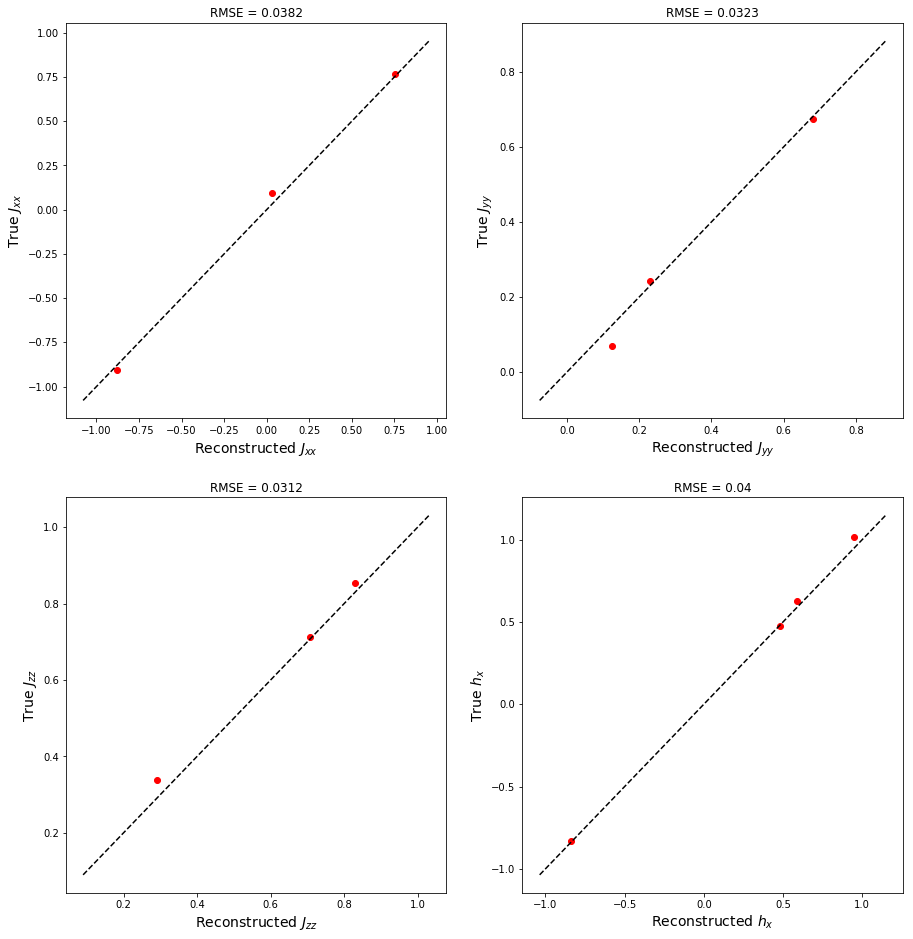

In [116]:
#plot recovered couplings against true values#

fig = plt.figure (figsize = (15, 16))
plt.subplot (2, 2, 1)
plt.plot ([min (Jxx) - 0.2, max (Jxx) + 0.2], [min (Jxx) - 0.2, max (Jxx) + 0.2], 'k--')
plt.scatter (Jxx, rec_J_xx, color = 'red')
plt.ylabel ('True $J_{xx}$', fontsize = 14)
plt.xlabel ('Reconstructed $J_{xx}$', fontsize = 14)
plt.title ('RMSE = {}'.format (round (np.sqrt (mse (Jxx, rec_J_xx)), 4)))

plt.subplot (2, 2, 2)
plt.plot ([min (Jyy) - 0.2, max (Jyy) + 0.2], [min (Jyy) - 0.2, max (Jyy) + 0.2], 'k--')
plt.scatter (Jyy, rec_J_yy, color = 'red')
plt.ylabel ('True $J_{yy}$', fontsize = 14)
plt.xlabel ('Reconstructed $J_{yy}$', fontsize = 14)
plt.title ('RMSE = {}'.format (round (np.sqrt (mse (Jyy, rec_J_yy)), 4)))

plt.subplot (2, 2, 3)
plt.plot ([min (Jzz) - 0.2, max (Jzz) + 0.2], [min (Jzz) - 0.2, max (Jzz) + 0.2], 'k--')
plt.scatter (Jzz, rec_J_zz, color = 'red')
plt.ylabel ('True $J_{zz}$', fontsize = 14)
plt.xlabel ('Reconstructed $J_{zz}$', fontsize = 14)
plt.title ('RMSE = {}'.format (round (np.sqrt (mse (Jzz, rec_J_zz)), 4)))

plt.subplot (2, 2, 4)
plt.plot ([min (hx) - 0.2, max (hx) + 0.2], [min (hx) - 0.2, max (hx) + 0.2], 'k--')
plt.scatter (hx, rec_h_x, color = 'red')
plt.ylabel ('True $h_{x}$', fontsize = 14)
plt.xlabel ('Reconstructed $h_{x}$', fontsize = 14)
plt.title ('RMSE = {}'.format (round (np.sqrt (mse (hx, rec_h_x)), 4)))
plt.savefig ('fully_connected')

### Experiment with different number of measurement bases

In [23]:
N_meas = 2000 #number of projective measurements

n_bases = np.arange (2, 3**N_spins, 2)

rmse = np.zeros (len (n_bases))

n_realizations = 20 # number of realizations for each basis in a loop

for i, n_b in enumerate (n_bases):
    
    rmse_tmp = list ()
    
    for n_r in range (n_realizations):
    
        Jxx = np.random.uniform (-1, 1, N_spins - 1)
        Jyy = np.random.uniform (-1, 1, N_spins - 1)
        Jzz = np.random.uniform (-1, 1, N_spins - 1)
        h = np.random.uniform (-1, 1, N_spins)

        Jarr = np.concatenate ((Jxx, Jyy, Jzz, h))
        x0 = np.ones (len (Jarr)) * 0.2
        rho = density_matr (N_spins, Jxx, Jyy, Jzz, h, beta)
        rot_matrices_xyz = rot_matr (xyz_rot_angles(N_spins))
        diag = get_rho_diag (rho, rot_matrices_xyz)

        log = dict ()

        batch_ds = get_batch_dataset (diag, n_b, N_meas)

        res = minimize (log_like, x0, method = 'COBYLA', args = (N_spins, batch_ds, log, beta), 
                options = {'maxiter': 3000})

        true = Jarr
        predicted = res ['x']
        err = np.sqrt (mse (true, predicted))
        rmse_tmp.append (err)
    
    rmse [i] = np.mean (rmse_tmp)

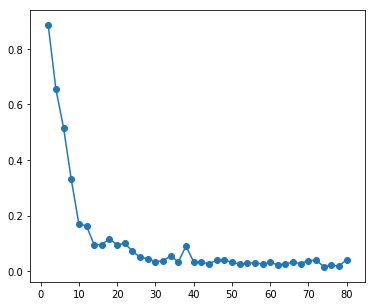

In [24]:
fig = plt.figure (figsize = (6, 5))
plt.plot (n_bases, rmse)
plt.scatter (n_bases, rmse)
plt.xlabel ('Basis set size')
plt.ylabel ('RMSE')

### Results graph

In [86]:
# this cell outputs four graphs
# 1. Deviation between reconstructed and true couplings J
# 2. Deviation between reconstructed and true values of magnetic fields h
# 3. RMSE as a function of number of measurements for different basis sets (b = 3**N, int (3**N/2), int (3**N/4))
# 4. Empirical probability of reconstruction (P_emp) as a 
# function of number of measurements for the same amount of basis sets
# P_emp defined as L_succ/L, where L is the number of realizations for each point on a plot, 
# L_succ - number of succesful realizations, L_succ is defined when RMSE < 0.05

n_bases = [3**N_spins, int (3**N_spins/2), int (3**N_spins/4)]
N_meas = np.arange (200, 2200, 200, dtype = 'int32')
n_realizations = 20

rmse_matr = np.zeros ((len (n_bases), len (N_meas)))
p_emp_matr = np.zeros ((len (n_bases), len (N_meas)))

for i, n_b in enumerate (n_bases):
    for j, n_m in enumerate (N_meas):
        rmse_tmp = np.zeros (n_realizations)
        for l in range (n_realizations):
            
            Jxx = np.random.uniform (-1, 1, N_spins - 1)
            Jyy = np.random.uniform (-1, 1, N_spins - 1)
            Jzz = np.random.uniform (-1, 1, N_spins - 1)
            h = np.random.uniform (-1, 1, N_spins)

            Jarr = np.concatenate ((Jxx, Jyy, Jzz, h))
            x0 = np.ones (len (Jarr)) * 0.2
            rho = density_matr (N_spins, Jxx, Jyy, Jzz, h, beta)
            rot_matrices_xyz = rot_matr (xyz_rot_angles(N_spins))
            diag = get_rho_diag (rho, rot_matrices_xyz)

            log = dict ()
            #print (n_b, n_m)

            batch_ds = get_batch_dataset (diag, n_b, n_m)

            res = minimize (log_like, x0, method = 'COBYLA', args = (N_spins, batch_ds, log, beta), 
                    options = {'maxiter': 3000})

            true = Jarr
            predicted = res ['x']
            err = np.sqrt (mse (true, predicted))
            rmse_tmp [l] = err
        
        fin_rmse = np.mean (rmse_tmp)
        l_succ = len (np.argwhere (rmse_tmp < 0.05))
        p_emp = l_succ / len (rmse_tmp)
        rmse_matr [i, j] = fin_rmse
        p_emp_matr [i, j] = p_emp
    #print (rmse_matr, p_emp_matr)
        
            
    
    

In [90]:
np.save ('rmse_matr', rmse_matr)
np.save ('p_emp_matr', p_emp_matr)

In [95]:
rmse_mat = np.load ('rmse_matr.npy')
p_emp_mat = np.load ('p_emp_matr.npy')

Text(0, 0.5, '$P_{emp}$')

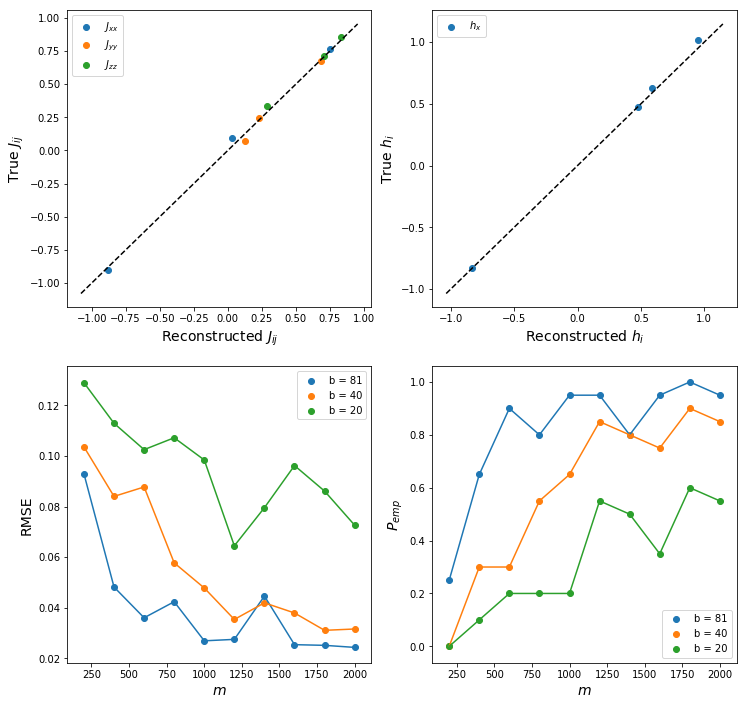

In [129]:
fig = plt.figure (figsize = (12, 12))

acc_3N = rmse_mat [0]
acc_3N_2 = rmse_mat [1]
acc_3N_4 = rmse_mat [2]

p_emp_3N = p_emp_mat [0]
p_emp_3N_2 = p_emp_mat [1]
p_emp_3N_4 = p_emp_mat [2]
N_meas = np.arange (200, 2200, 200, dtype = 'int32')

plt.subplot (2, 2, 1)
plt.plot ([min (Jxx) - 0.2, max (Jxx) + 0.2], [min (Jxx) - 0.2, max (Jxx) + 0.2], 'k--')
plt.scatter (Jxx, rec_J_xx, label = '$J_{xx}$')
plt.scatter (Jyy, rec_J_yy, label = '$J_{yy}$')
plt.scatter (Jzz, rec_J_zz, label = '$J_{zz}$')
plt.ylabel ('True $J_{ij}$', fontsize = 14)
plt.xlabel ('Reconstructed $J_{ij}$', fontsize = 14)
plt.legend (loc = 'best')

plt.subplot (2, 2, 2)
plt.plot ([min (hx) - 0.2, max (hx) + 0.2], [min (hx) - 0.2, max (hx) + 0.2], 'k--')
plt.scatter (hx, rec_h_x, label = '$h_{x}$')
plt.ylabel ('True $h_{i}$', fontsize = 14)
plt.xlabel ('Reconstructed $h_{i}$', fontsize = 14)
plt.legend (loc = 'best')

plt.subplot (2, 2, 3)
plt.plot (N_meas, acc_3N)
plt.scatter (N_meas, acc_3N, label = 'b = {}'.format (3**N_spins))
plt.plot (N_meas, acc_3N_2)
plt.scatter (N_meas, acc_3N_2, label = 'b = {}'.format (int (3**N_spins/2)))
plt.plot (N_meas, acc_3N_4)
plt.scatter (N_meas, acc_3N_4, label = 'b = {}'.format (int (3**N_spins/4)))
plt.legend (loc = 'best')
plt.xlabel ('$m$', fontsize = 14)
plt.ylabel ('RMSE', fontsize = 14)

plt.subplot (2, 2, 4)
plt.plot (N_meas, p_emp_3N)
plt.scatter (N_meas, p_emp_3N, label = 'b = {}'.format (3**N_spins))
plt.plot (N_meas, p_emp_3N_2)
plt.scatter (N_meas, p_emp_3N_2, label = 'b = {}'.format (int (3**N_spins/2)))
plt.plot (N_meas, p_emp_3N_4)
plt.scatter (N_meas, p_emp_3N_4, label = 'b = {}'.format (int (3**N_spins/4)))
plt.legend (loc = 'best')
plt.xlabel ('$m$', fontsize = 14)
plt.ylabel ('$P_{emp}$', fontsize = 14)